# Introduction

哈罗，各位 ~ 本文对[安泰杯 —— 跨境电商智能算法大赛](https://tianchi.aliyun.com/competition/entrance/231718/information)数据进行了初探与可视化处理，便于各位更为直观理解赛题数据与建模目标。

    
[赛题目标](https://tianchi.aliyun.com/competition/entrance/231718/introduction)：通过用户历史订单数据，预测用户下一次购买的商品。

[赛题数据](https://tianchi.aliyun.com/competition/entrance/231718/information)：数据保存为四个文件中，训练数据(Antai_AE_round1_train_20190626.csv)、测试数据(Antai_AE_round1_test_20190626.csv)、商品信息(Antai_AE_round1_item_attr_20190626.csv)、提交示例(Antai_AE_round1_submit_20190715.csv)

1. 训练数据：用户每次购买的商品id，订单日期以及用户国家标识

2. 测试数据：较于训练数据，测试数据剔除了用户需要预测最后一次购买记录

3. 商品信息：商品id、品类id、店铺id和商品价格

4. 提交示例：预测用户购买商品Top30的item_id依概率从高到低排序，buyer_admin_id,predict 1,predict 2,…,predict 30


代码运行环境：
    
    JupyterLab
    Python 3.5
    Pandas 0.24.2
    matplotlib 3.0.2
    seaborn 0.9.0

## 载入数据分析库包

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import gc
%matplotlib inline
# 禁用科学计数法
pd.set_option('display.float_format',lambda x : '%.2f' % x)

## 读取数据

In [3]:
import os
os.chdir(os.path.dirname(os.path.abspath(__name__)))
item = pd.read_csv('../data/Antai_AE_round1_item_attr_20190626.csv')
train = pd.read_csv('../data/Antai_AE_round1_train_20190626.csv')
test = pd.read_csv('../data/Antai_AE_round1_test_20190626.csv')
submit = pd.read_csv('../data/Antai_AE_round1_submit_20190715.csv')

### 数据预处理
* 合并train和test文件
* 提取日期年月日等信息
* 关联商品价格、品类、店铺
* 转化每列数据类型为可存储的最小值，减少内存消耗
* 保存为hdf5格式文件，加速读取

In [4]:
df = pd.concat([train.assign(is_train=1), test.assign(is_train=0)])

df['create_order_time'] = pd.to_datetime(df['create_order_time'])
df['date'] = df['create_order_time'].dt.date
df['day'] = df['create_order_time'].dt.day
df['hour'] = df['create_order_time'].dt.hour

df = pd.merge(df, item, how='left', on='item_id')

In [5]:
memory = df.memory_usage().sum() / 1024**2 
print('Before memory usage of properties dataframe is :', memory, " MB")

dtype_dict = {'buyer_admin_id' : 'int32', 
              'item_id' : 'int32', 
              'store_id' : pd.Int32Dtype(),
              'irank' : 'int16',
              'item_price' : pd.Int16Dtype(),
              'cate_id' : pd.Int16Dtype(),
              'is_train' : 'int8',
              'day' : 'int8',
              'hour' : 'int8',
             }

df = df.astype(dtype_dict)
memory = df.memory_usage().sum() / 1024**2 
print('After memory usage of properties dataframe is :', memory, " MB")
del train,test; gc.collect()

Before memory usage of properties dataframe is : 1292.8728713989258  MB
After memory usage of properties dataframe is : 696.1623153686523  MB


27

In [6]:
for col in ['store_id', 'item_price', 'cate_id']:
    df[col] = df[col].fillna(0).astype(np.int32).replace(0, np.nan)

!pip install tables
df.to_hdf('../data/train_test.h5', '1.0')

d:\env\anaconda\envs\gpytorch\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '1.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\Chen Yang\AppData\Local\Temp\ipykernel_23692\3225464216.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['buyer_country_id', 'date'], dtype='object')]

  df.to_hdf('../data/train_test.h5', '1.0')


In [7]:
%%time
df = pd.read_hdf('../data/train_test.h5', '1.0')

CPU times: total: 1.16 s
Wall time: 4.51 s


In [8]:
%%time
train = pd.read_csv('../data/Antai_AE_round1_train_20190626.csv')
test = pd.read_csv('../data/Antai_AE_round1_test_20190626.csv')
item = pd.read_csv('../data/Antai_AE_round1_item_attr_20190626.csv')
del train, test; gc.collect()

CPU times: total: 1.23 s
Wall time: 7.01 s


0

经过前处理后:
* 文件内存占用从1200M减少至600M
* 采用hdf5格式存储，读取时间从15秒减少到仅需5秒

# Overview: 数据内容

* 用户、商品、店铺、品类乃至商品价格都是从1开始用整数编号
* 订单日期格式为：YYYY-mm-dd HH:mm:ss
* 源数据中都木有空值，但是由于某些商品，不在商品表，因此缺少了一些价格、品类信息。

In [9]:
df.head()

,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank,is_train,date,day,hour,cate_id,store_id,item_price
0,xx,8362078,1,2018-08-10 23:49:44,12,1,2018-08-10,10,23,2324.00,10013.00,4501.00
1,xx,9694304,2,2018-08-03 23:55:07,9,1,2018-08-03,3,23,3882.00,4485.00,2751.00
2,yy,101887,3,2018-08-27 08:31:26,3,1,2018-08-27,27,8,155.00,8341.00,656.00
3,xx,8131786,3,2018-08-31 06:00:19,9,1,2018-08-31,31,6,155.00,8341.00,656.00
4,xx,9778613,5,2018-08-21 06:01:56,14,1,2018-08-21,21,6,1191.00,1949.00,1689.00


每列数据的真实含义：

buyer_country_id: 买家国家id, 只有'xx'和'yy'两种取值

buyer_admin_id: 买家id

item_id: 商品id

create_order_time: 订单创建时间

irank: 每个买家对应的所有记录按照时间顺序的逆排序

is_train: 是否为训练数据

cate_id: 类别id

store_id: 商店id

item_price: 商品价格

In [10]:
# Null 空值统计
for pdf in [df, item]:
    for col in pdf.columns:
        print(col, pdf[col].isnull().sum())

buyer_country_id 0
buyer_admin_id 0
item_id 0
create_order_time 0
irank 0
is_train 0
date 0
day 0
hour 0
cate_id 26119
store_id 26119
item_price 26119
item_id 0
cate_id 0
store_id 0
item_price 0


In [11]:
df.describe()

,buyer_admin_id,item_id,irank,is_train,day,hour,cate_id,store_id,item_price
count,13035341.00,13035341.00,13035341.00,13035341.00,13035341.00,13035341.00,13009222.00,13009222.00,13009222.00
mean,6527293.86,6522519.78,143.62,0.99,18.62,9.06,1498.53,40575.67,1099.75
std,3764280.24,3765432.09,1573.84,0.11,9.21,6.56,903.26,24284.46,2880.00
min,1.00,1.00,-32768.00,0.00,1.00,0.00,1.00,1.00,1.00
25%,3269515.00,3261386.00,4.00,1.00,10.00,4.00,616.00,20648.00,123.00
50%,6528429.00,6522878.00,8.00,1.00,19.00,8.00,1505.00,39368.00,246.00
75%,9787265.00,9784900.00,16.00,1.00,27.00,13.00,2010.00,59273.00,700.00
max,13046721.00,13046734.00,32767.00,1.00,31.00,23.00,4243.00,95105.00,20230.00


In [12]:
item.describe()

,item_id,cate_id,store_id,item_price
count,2832669.00,2832669.00,2832669.00,2832669.00
mean,6429138.00,1481.10,40256.46,1124.00
std,3725431.44,923.09,24370.92,2110.62
min,1.00,1.00,1.00,1.00
25%,3224114.00,600.00,19850.00,180.00
50%,6391845.00,1499.00,38954.00,400.00
75%,9636216.00,2050.00,58406.00,1200.00
max,13046734.00,4243.00,95105.00,20230.00


# 数据探查

下一步，我们依次对每个文件的特征进行基础统计和可视化处理，这是对数据进一步理解的基础。


## 训练集与测试集

In [13]:
train = df['is_train']==1
test = df['is_train']==0

In [14]:
train_count = len(df[train])
print('训练集样本量是',train_count)
test_count = len(df[test])
print('测试集样本量是',test_count)
print('样本比例为：', train_count/test_count)

训练集样本量是 12868509
测试集样本量是 166832
样本比例为： 77.13453653975256


### buyer_country_id 国家编号

In [15]:
def groupby_cnt_ratio(df, col):
    if isinstance(col, str):
        col = [col]
    key = ['is_train', 'buyer_country_id'] + col
    
    # groupby function
    cnt_stat = df.groupby(key).size().to_frame('count')
    # cnt_stat = df.groupby(key).to_frame('count')
    ratio_stat = (cnt_stat / cnt_stat.groupby(['is_train', 'buyer_country_id']).sum()).rename(columns={'count':'count_ratio'})
    return pd.merge(cnt_stat, ratio_stat, on=key, how='outer').sort_values(by=['count'], ascending=False)

In [16]:
groupby_cnt_ratio(df, [])

count  count_ratio
is_train buyer_country_id                       
1        xx                10635642         1.00
         yy                 2232867         1.00
0        yy                  166832         1.00

Text(0.5, 1.0, '国家编号')

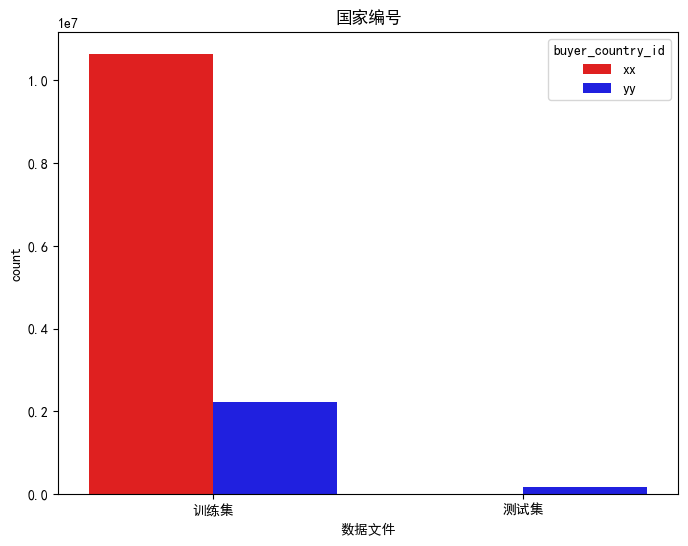

In [67]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.figure(figsize=(8,6))
sns.countplot(x='is_train', data = df, palette=['red', 'blue'], hue='buyer_country_id', order=[1, 0])
plt.xticks(np.arange(2), ('训练集', '测试集'))
plt.xlabel('数据文件')
plt.title('国家编号')

buyer_country_id 国家编号

> 本次比赛给出若干日内来自成熟国家的部分用户的行为数据，以及来自待成熟国家的A部分用户的行为数据，以及待成熟国家的B部分用户的行为数据去除每个用户的最后一条购买数据，让参赛人预测B部分用户的最后一条行为数据。

* 训练集中有2个国家数据，xx国家样本数10635642，占比83%，yy国家样本数2232867条，仅占17%
* 预测集中有yy国家的166832数据, 训练集中yy国样本数量是测试集中的13倍，如赛题目的所言，期望通过大量成熟国家来预测少量带成熟国家的用户购买行为

### buyer_admin_id 用户编号

In [18]:
print('训练集中用户数量',len(df[train]['buyer_admin_id'].unique()))
print('测试集中用户数量',len(df[test]['buyer_admin_id'].unique()))

训练集中用户数量 809213
测试集中用户数量 11398


In [19]:
union = list(set(df[train]['buyer_admin_id'].unique()).intersection(set(df[test]['buyer_admin_id'].unique())))
print('同时在训练集测试集出现的有6位用户，id如下：',union)

同时在训练集测试集出现的有6位用户，id如下： [12647969, 13000419, 3106927, 12858772, 12929117, 12368445]


In [20]:
df[train][df['buyer_admin_id'].isin(union)].sort_values(by=['buyer_admin_id','irank']).head(10)

C:\Users\Chen Yang\AppData\Local\Temp\ipykernel_23692\3035833051.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[train][df['buyer_admin_id'].isin(union)].sort_values(by=['buyer_admin_id','irank']).head(10)


,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank,is_train,date,day,hour,cate_id,store_id,item_price
7546704,xx,3106927,7645546,2018-08-30 02:49:22,1,1,2018-08-30,30,2,1164.00,73781.00,770.00
4582539,xx,3106927,4639151,2018-08-30 02:49:22,2,1,2018-08-30,30,2,2214.00,53190.00,1669.00
11953258,xx,3106927,12122118,2018-08-30 02:49:22,3,1,2018-08-30,30,2,236.00,73781.00,884.00
255625,xx,3106927,258860,2018-08-30 02:49:22,4,1,2018-08-30,30,2,189.00,24221.00,900.00
7402817,xx,3106927,7499372,2018-08-30 02:49:22,5,1,2018-08-30,30,2,2214.00,32535.00,2714.00
9483312,xx,3106927,9613063,2018-08-30 02:49:22,6,1,2018-08-30,30,2,3069.00,73781.00,110.00
2740080,xx,3106927,2773189,2018-08-27 08:18:23,10,1,2018-08-27,27,8,1865.00,49499.00,20067.00
12152249,xx,3106927,12324030,2018-08-27 07:15:05,11,1,2018-08-27,27,7,880.00,92968.00,1764.00
2201292,xx,3106927,2227720,2018-08-19 02:36:36,12,1,2018-08-19,19,2,1164.00,6404.00,1900.00
6717641,xx,3106927,6804187,2018-08-19 02:33:39,13,1,2018-08-19,19,2,1164.00,52421.00,230.00


In [21]:
df[test][df['buyer_admin_id'].isin(union)].sort_values(by=['buyer_admin_id','irank']).head(3)

C:\Users\Chen Yang\AppData\Local\Temp\ipykernel_23692\3087106983.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[test][df['buyer_admin_id'].isin(union)].sort_values(by=['buyer_admin_id','irank']).head(3)


,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank,is_train,date,day,hour,cate_id,store_id,item_price
13016145,yy,3106927,202354,2018-08-30 02:48:40,7,0,2018-08-30,30,2,642.00,24221.00,989.00
13008981,yy,3106927,6994414,2018-08-29 05:48:06,8,0,2018-08-29,29,5,7.00,37411.00,1521.00
13008982,yy,3106927,6994414,2018-08-29 05:48:06,9,0,2018-08-29,29,5,7.00,37411.00,1521.00


In [22]:
# 找出训练集中三位用户的最新购买记录
df[(train) & (df['irank']==1) & (df['buyer_admin_id'].isin(['12858772','3106927','12368445']))]

,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank,is_train,date,day,hour,cate_id,store_id,item_price


emmm... 为啥同一个用户在训练集和测试集国家不一样了呢？但是其他信息能对上。。。，而且rank=1的结果直接给出来了。。。

<font color='red'>因为题目中说过用户可能会跨国购买</font>

id为12858772、3106927、12368445直接把结果给出来

可能是数据清洗出问题了，后面再看看怎么处理

#### 用户记录数分布

In [23]:
admin_cnt = groupby_cnt_ratio(df, 'buyer_admin_id')
admin_cnt.groupby(['is_train','buyer_country_id']).head(3)

count  count_ratio
is_train buyer_country_id buyer_admin_id                    
1        xx               10828801        42751         0.00
                          10951390        23569         0.00
                          11223615        19933         0.00
         yy               2381782          3480         0.00
                          2333316          1944         0.00
                          2365356          1686         0.00
0        yy               2041038          1386         0.01
                          2070430           399         0.00
                          1144848           286         0.00

In [24]:
# 用户购买记录数——最多、最少、中位数
admin_cnt.groupby(['is_train','buyer_country_id'])['count'].agg(['max','min','median'])

max  min  median
is_train buyer_country_id                    
0        yy                 1386    7   11.00
1        xx                42751    8   11.00
         yy                 3480    8   12.00

C:\Users\Chen Yang\AppData\Local\Temp\ipykernel_23692\3368091053.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.kdeplot(admin_cnt.loc[(1, 'xx')]['count'].values, ax=ax[0]).set_title('训练集--xx国用户记录数')
C:\Users\Chen Yang\AppData\Local\Temp\ipykernel_23692\3368091053.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.kdeplot(admin_cnt[admin_cnt['count']<50].loc[(1, 'yy')]['count'].values, ax=ax[1]).set_title('yy国用户记录数')
C:\Users\Chen Yang\AppData\Local\Temp\ipykernel_23692\3368091053.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.kdeplot(admin_cnt[admin_cnt['count']<50].loc[(0, 'yy')]['count'].values, ax=ax[1]);


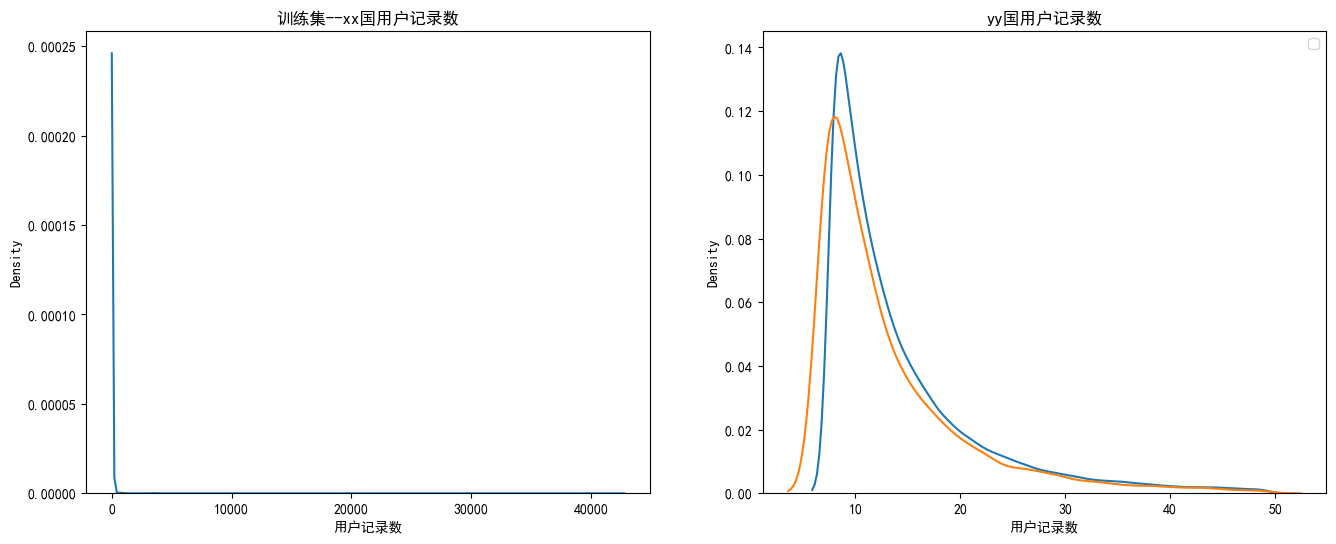

In [25]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
fig, ax = plt.subplots(1, 2 ,figsize=(16,6))
ax[0].set(xlabel='用户记录数')
sns.kdeplot(admin_cnt.loc[(1, 'xx')]['count'].values, ax=ax[0]).set_title('训练集--xx国用户记录数')

ax[1].legend(labels=['训练集', '测试集'], loc="upper right")
ax[1].set(xlabel='用户记录数')
sns.kdeplot(admin_cnt[admin_cnt['count']<50].loc[(1, 'yy')]['count'].values, ax=ax[1]).set_title('yy国用户记录数')
sns.kdeplot(admin_cnt[admin_cnt['count']<50].loc[(0, 'yy')]['count'].values, ax=ax[1]);

用户记录数进行了一波简单的探查：
* 训练集中记录了*809213*个用户的数据，其中id为10828801的用户拔得头筹，有42751条购买记录，用户至少都有8条记录
* 训练集中记录了*11398*个用户的数据，其中id为2041038的用户勇冠三军，有1386条购买记录，用户至少有7条记录

Notes: 验证集中用户最少仅有7条，是因为最后一条记录被抹去

从上面数据和图表看到，用户记录数大都都分布在0~50，少量用户记录甚至超过了10000条，下一步对用户记录数分布继续探索

In [26]:
admin_cnt.columns = ['记录数', '占比']
admin_user_cnt = groupby_cnt_ratio(admin_cnt, '记录数')
admin_user_cnt.columns = ['人数', '人数占比']
admin_user_cnt.head()

人数  人数占比
is_train buyer_country_id 记录数              
1        xx               8    118155  0.18
                          9     91757  0.14
                          10    72936  0.11
                          11    57678  0.09
                          12    46534  0.07

In [27]:
# xx国——用户记录数与用户数
admin_user_cnt.loc[(1,'xx')][['人数','人数占比']]

C:\Users\Chen Yang\AppData\Local\Temp\ipykernel_23692\2179141034.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  admin_user_cnt.loc[(1,'xx')][['人数','人数占比']]


,人数,人数占比
记录数,,
8,118155,0.18
9,91757,0.14
10,72936,0.11
11,57678,0.09
12,46534,0.07
...,...,...
537,1,0.00
545,1,0.00
549,1,0.00


In [28]:
# yy国——记录数与用户数占比
admin_user_cnt.loc[([1,0],'yy',slice(None))][['人数','人数占比']].unstack(0).drop('人数',1).head(10)

C:\Users\Chen Yang\AppData\Local\Temp\ipykernel_23692\3317520794.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  admin_user_cnt.loc[([1,0],'yy',slice(None))][['人数','人数占比']].unstack(0).drop('人数',1).head(10)


人数占比     
is_train                0    1
buyer_country_id 记录数          
yy               8   0.13 0.16
                 9   0.10 0.13
                 10  0.09 0.10
                 11  0.08 0.08
                 12  0.06 0.07
                 13  0.05 0.06
                 14  0.04 0.05
                 15  0.04 0.04
                 16  0.03 0.03
                 17  0.03 0.03

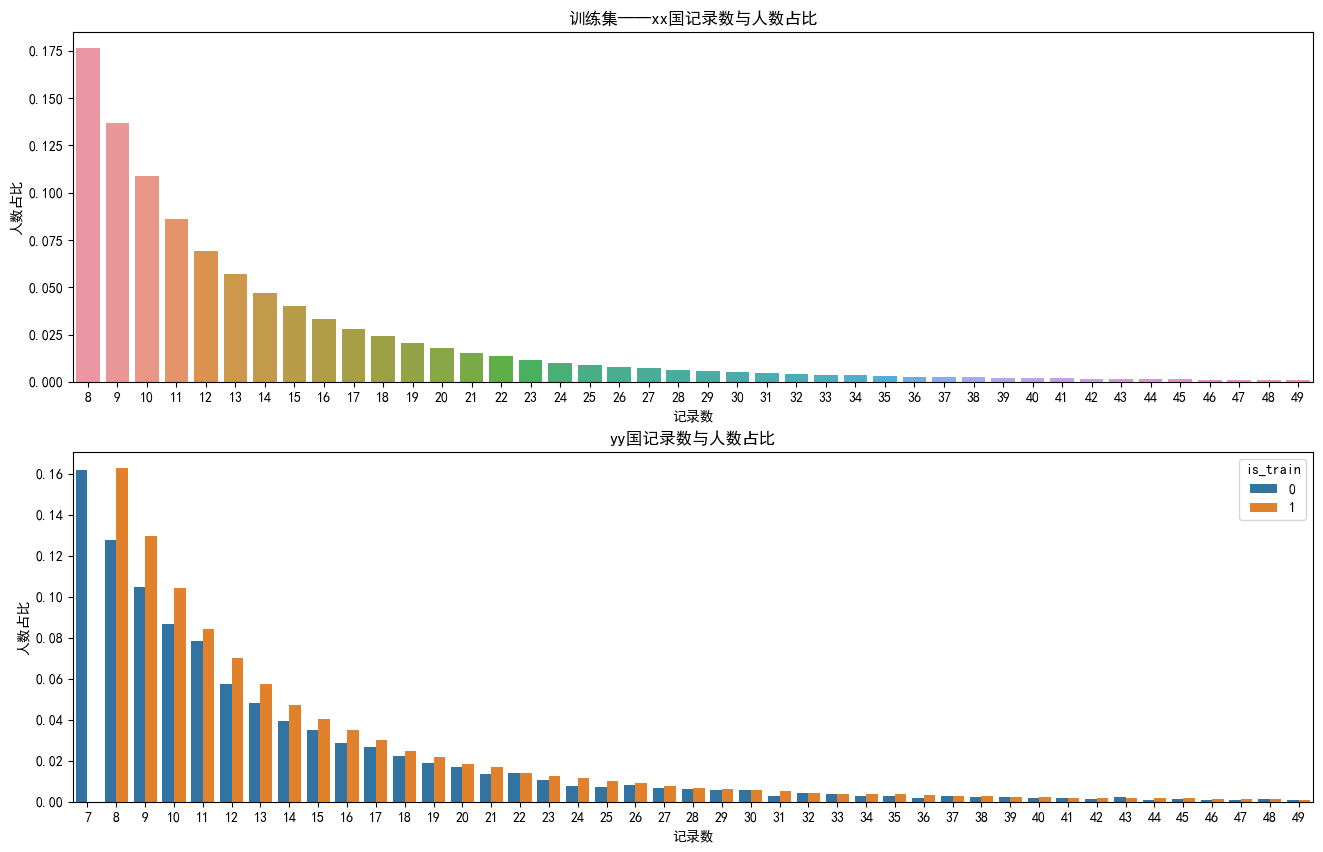

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(16,10))
admin_plot = admin_user_cnt.reset_index()
sns.barplot(x='记录数', y='人数占比', data=admin_plot[(admin_plot['记录数']<50) & (admin_plot['buyer_country_id']=='xx')], 
            estimator=np.mean, ax=ax[0]).set_title('训练集——xx国记录数与人数占比');

sns.barplot(x='记录数', y='人数占比', hue='is_train', data=admin_plot[(admin_plot['记录数']<50) & (admin_plot['buyer_country_id']=='yy')], 
            estimator=np.mean, ax=ax[1]).set_title('yy国记录数与人数占比');

用户记录数进一步探查结论：

    * 不管是训练集还是验证集，99%的用户购买记录都在50条内，这是比较符合正常逻辑
    
    * TODO:对于发生大量购买行为的用户，后面再单独探查，是否有其他规律或疑似刷单现象

### item_id 商品编号

In [30]:
print('商品表中商品数：',len(item['item_id'].unique()))
print('训练集中商品数：',len(df[train]['item_id'].unique()))
print('验证集中商品数：',len(df[test]['item_id'].unique()))
print('仅训练集有的商品数：',len(list(set(df[train]['item_id'].unique()).difference(set(df[test]['item_id'].unique())))))
print('仅验证集有的商品数：',len(list(set(df[test]['item_id'].unique()).difference(set(df[train]['item_id'].unique())))))
print('训练集验证集共同商品数：',len(list(set(df[train]['item_id'].unique()).intersection(set(df[test]['item_id'].unique())))))
print('训练集中不在商品表的商品数：',len(list(set(df[train]['item_id'].unique()).difference(set(item['item_id'].unique())))))
print('验证集中不在商品表的商品数：',len(list(set(df[test]['item_id'].unique()).difference(set(item['item_id'].unique())))))

商品表中商品数： 2832669
训练集中商品数： 2812048
验证集中商品数： 104735
仅训练集有的商品数： 2735801
仅验证集有的商品数： 28488
训练集验证集共同商品数： 76247
训练集中不在商品表的商品数： 7733
验证集中不在商品表的商品数： 313


#### 商品销量

In [68]:
item_cnt = groupby_cnt_ratio(df, 'item_id')
item_cnt.columns=['销量', '总销量占比']
item_cnt.reset_index(inplace=True)
item_cnt.head(3)

,is_train,buyer_country_id,item_id,销量,总销量占比
0,1,xx,12691565,112659,0.01
1,1,xx,12824199,35979,0.00
2,1,xx,12673275,14668,0.00


In [69]:
top_item_plot = item_cnt.groupby(['is_train','buyer_country_id']).head(10)
top_item_plot

,is_train,buyer_country_id,item_id,销量,总销量占比
0,1,xx,12691565,112659,0.01
1,1,xx,12824199,35979,0.00
2,1,xx,12673275,14668,0.00
3,1,xx,12891086,12335,0.00
4,1,xx,634028,7900,0.00
5,1,xx,10266898,6079,0.00
6,1,xx,10027998,5539,0.00
7,1,xx,12049470,5357,0.00
8,1,xx,12817558,4915,0.00
9,1,xx,1359800,4708,0.00


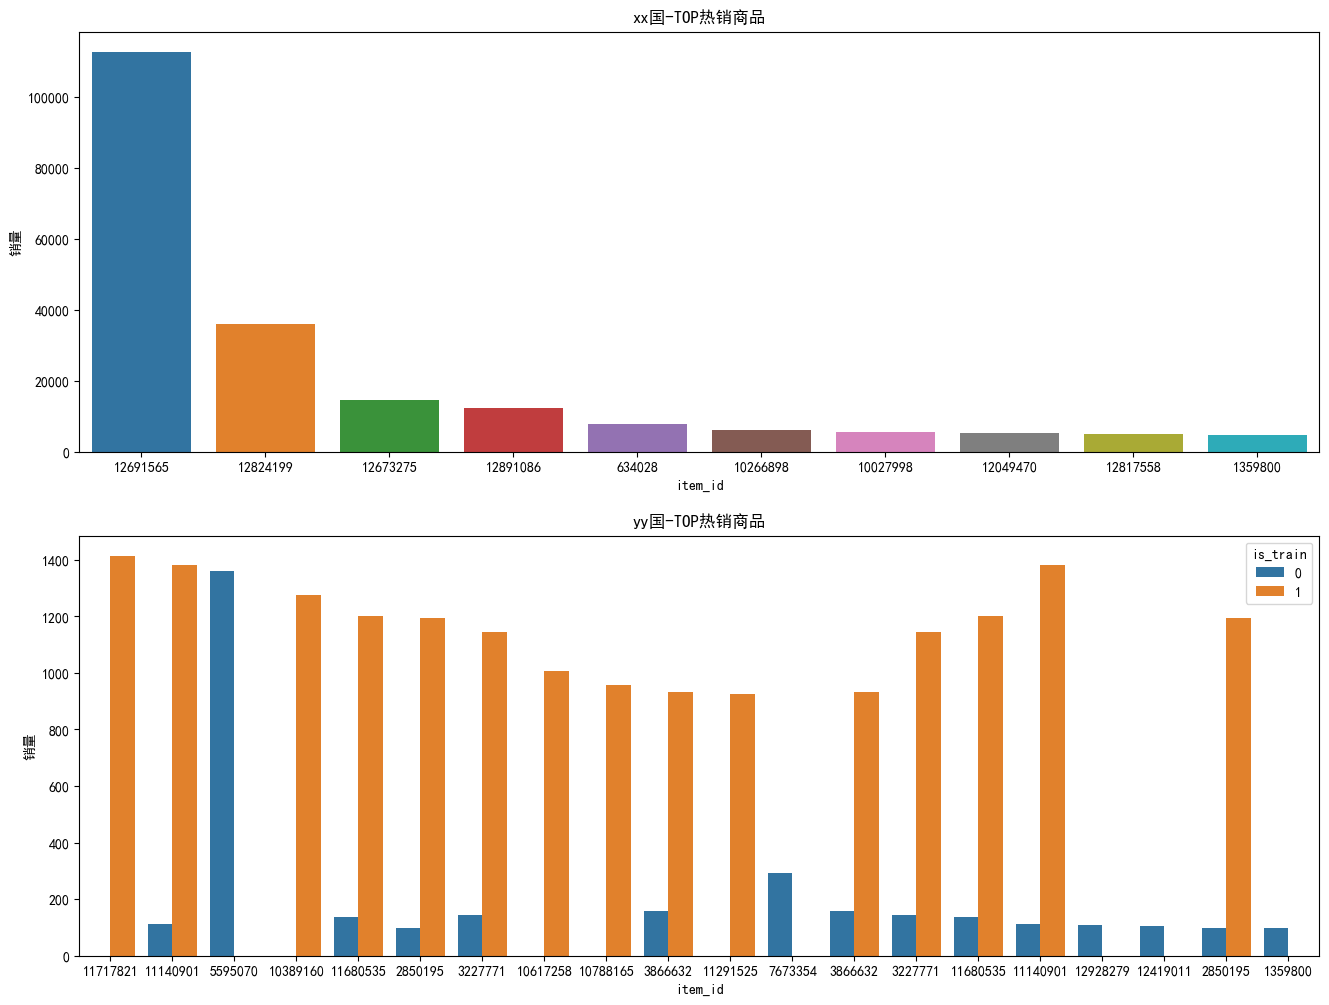

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(16,12))
sns.barplot(x='item_id', y='销量', data=top_item_plot[top_item_plot['buyer_country_id']=='xx'], 
            order=top_item_plot['item_id'][top_item_plot['buyer_country_id']=='xx'], ax=ax[0], estimator=np.mean).set_title('xx国-TOP热销商品')
sns.barplot(x='item_id', y='销量', hue='is_train', data=top_item_plot[top_item_plot['buyer_country_id']=='yy'], 
            order=top_item_plot['item_id'][top_item_plot['buyer_country_id']=='yy'], ax=ax[1], estimator=np.mean).set_title('yy国-TOP热销商品');

初步数据发现：
* 训练集中出售最多商品是12691565，卖了112659次。
* 测试集中出售最多商品是5595070，卖了1359次。
* 大部分商品只有1次出售记录，符合电商长尾属性
* 比较奇怪的yy国中，训练集和测试集中热销商品并不太一样

#### 整体商品销量分布

In [70]:
item_order_cnt = groupby_cnt_ratio(item_cnt, '销量')
item_order_cnt.columns = ['商品数', '占比']
item_order_cnt.head()

商品数   占比
is_train buyer_country_id 销量              
1        xx               1   1331056 0.58
         yy               1    625041 0.67
         xx               2    361829 0.16
                          3    164953 0.07
         yy               2    139607 0.15

In [71]:
item_order_cnt.groupby(['is_train','buyer_country_id']).head(5).sort_values(by=['buyer_country_id','is_train'])

商品数   占比
is_train buyer_country_id 销量              
1        xx               1   1331056 0.58
                          2    361829 0.16
                          3    164953 0.07
                          4     95629 0.04
                          5     61551 0.03
0        yy               1     81212 0.78
                          2     13083 0.12
                          3      4350 0.04
                          4      2123 0.02
                          5      1200 0.01
1        yy               1    625041 0.67
                          2    139607 0.15
                          3     55274 0.06
                          4     29848 0.03
                          5     17782 0.02

In [36]:
item_order_plot = item_order_cnt.reset_index()
item_order_plot = item_order_plot[item_order_plot['销量']<=8]

xx_item_order_plot = item_order_plot[item_order_plot['buyer_country_id']=='xx']
yy_item_order_plot = item_order_plot[item_order_plot['buyer_country_id']=='yy']
yy_item_order_plot_1 = yy_item_order_plot[yy_item_order_plot['is_train']==1]
yy_item_order_plot_0 = yy_item_order_plot[yy_item_order_plot['is_train']==0]

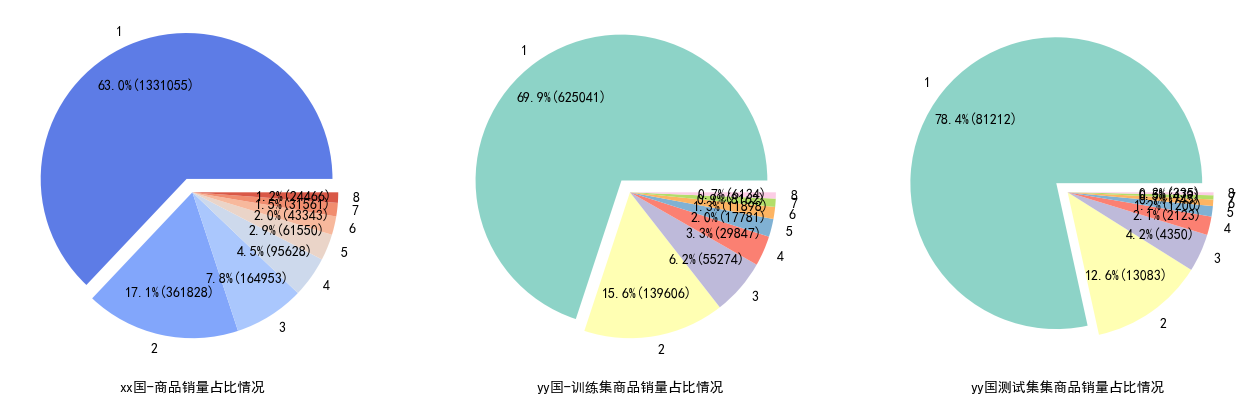

In [73]:
# 商品销量饼图
def text_style_func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%({:d})".format(pct, absolute)

def pie_param(ax, df, color_palette):
    return ax.pie(df['占比'].values, autopct=lambda pct: text_style_func(pct, df['商品数']), labels = df['销量'], 
                  explode = [0.1]+ np.zeros(len(df)-1).tolist(), pctdistance = 0.7, colors=sns.color_palette(color_palette, 8))

fig, ax = plt.subplots(1, 3, figsize=(16,12))
ax[0].set(xlabel='xx国-商品销量占比情况')
# ax[0].set(ylabel='xx国-商品数量比例')
pie_param(ax[0], xx_item_order_plot, "coolwarm")
ax[1].set(xlabel='yy国-训练集商品销量占比情况')
pie_param(ax[1], yy_item_order_plot_1, "Set3")
ax[2].set(xlabel='yy国测试集集商品销量占比情况')
pie_param(ax[2], yy_item_order_plot_0, "Set3");

In [38]:
print(xx_item_order_plot.head(10)['占比'].sum())
print(yy_item_order_plot_1.head(10)['占比'].sum())
print(yy_item_order_plot_0.head(10)['占比'].sum())

0.9215598591503256
0.9643666018897873
0.9884661288012603


总体来看，由于训练集数据远多于测试集数据：
* 训练集商品销量大于测试集商品销量
* 长尾趋势严重，热门商品少，大量商品仅有数次销售记录，1单商品占了绝大部分(均超过50%)
* 训练集中92%的商品销量不超过10件，而在测试集中97%的商品销量不超过10件
* 此外训练集中yy国的商品销量大于测试集

### cate_id 品类编号

In [39]:
print('商品品类数', len(item['cate_id'].unique()))
print('训练集商品品类数', len(df[train]['cate_id'].unique()))
print('测试集商品品类数', len(df[test]['cate_id'].unique()))

商品品类数 4243
训练集商品品类数 4239
测试集商品品类数 2727


#### 各个品类下商品数量

In [76]:
item.groupby(['cate_id']).size().to_frame('count').reset_index()

,cate_id,count
0,1,30
1,2,11885
2,3,46
3,4,936
4,5,2987
...,...,...
4238,4239,36
4239,4240,20
4240,4241,23
4241,4242,7


In [40]:
cate_cnt = item.groupby(['cate_id']).size().to_frame('count').reset_index()
cate_cnt.sort_values(by=['count'], ascending=False).head(5)

,cate_id,count
578,579,170074
2395,2396,44467
1497,1498,42676
599,600,39729
1591,1592,34820


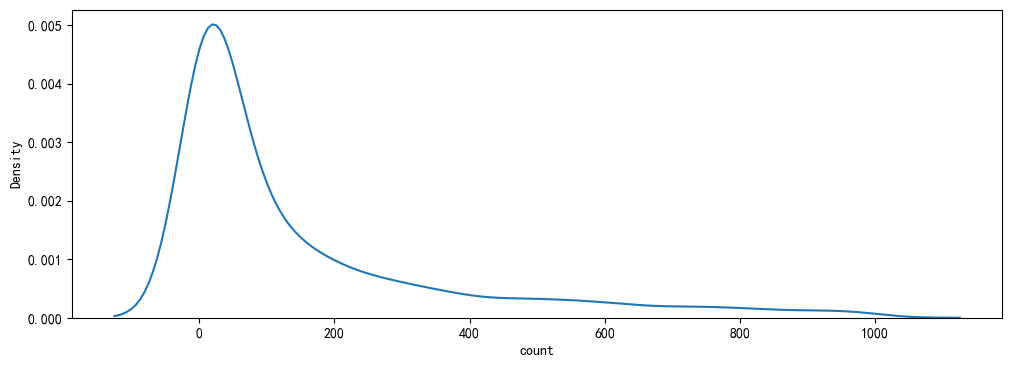

In [81]:
plt.figure(figsize=(12,4))
sns.kdeplot(data=cate_cnt[cate_cnt['count']<1000]['count']);

我们发现：

    * 579品类一花独秀有17W个商品，可能是平台主营方向
    
    * 大部分品类都在100个以上

### store_id 店铺编号

In [42]:
print('商品店铺数', len(item['store_id'].unique()))
print('训练集店铺数', len(df[train]['store_id'].unique()))
print('测试集店铺数', len(df[train]['store_id'].unique()))

商品店铺数 95105
训练集店铺数 94970
测试集店铺数 94970


#### 店铺下品类数量

In [86]:
item.groupby(['store_id']).head()

,item_id,cate_id,store_id,item_price
0,240607,1495,12239,1
1,285232,1498,12239,1
2,113669,1503,12239,1
3,253601,1422,12239,1
4,246568,1497,12239,1
...,...,...,...,...
2831815,12662087,2388,55288,19763
2831831,11462633,61,60684,19769
2832076,8208074,2865,43130,19882
2832081,8305340,2865,43130,19886


In [88]:
item.groupby(['store_id'])['cate_id'].nunique().head()

store_id
1    326
2      1
3      4
4      7
5      3
Name: cate_id, dtype: int64

In [43]:
store_cate_cnt = item.groupby(['store_id'])['cate_id'].nunique().to_frame('count').reset_index()    # count 为每个商店出售的商品类别总数
store_cate_cnt.sort_values(by=['count'], ascending=False).head(5)

,store_id,count
0,1,326
45594,45595,280
44983,44984,274
1870,1871,258
22034,22035,241


In [89]:
store_cate_cnt.groupby(['count']).size()

count
1      28641
2      16802
3      11216
4       7903
5       5789
       ...  
241        1
258        1
274        1
280        1
326        1
Length: 159, dtype: int64

In [82]:
store_cnt_cate_cnt = store_cate_cnt.groupby(['count']).size().reset_index()
store_cnt_cate_cnt.columns = ['店铺品类数', '店铺数量']
store_cnt_cate_cnt.head()

,店铺品类数,店铺数量
0,1,28641
1,2,16802
2,3,11216
3,4,7903
4,5,5789


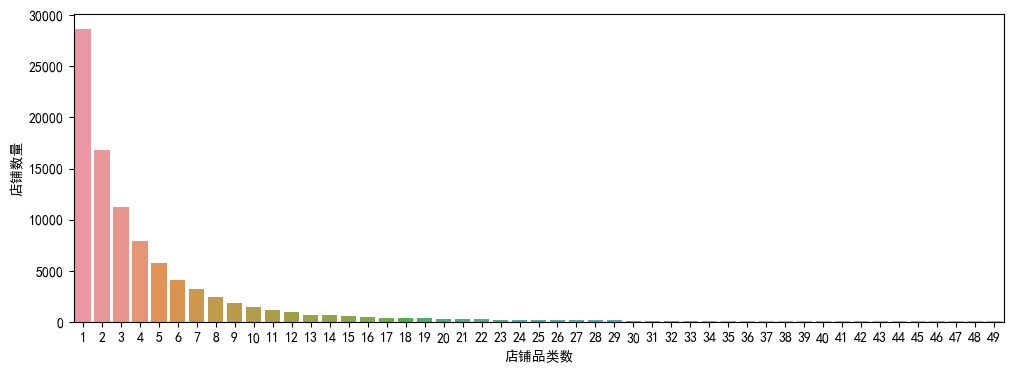

In [45]:
plt.figure(figsize=(12,4))
sns.barplot(x='店铺品类数', y='店铺数量', data=store_cnt_cate_cnt[store_cnt_cate_cnt['店铺品类数']<50], estimator=np.mean);

可以看出大部分商店只卖个位数种类的商品

#### 店铺下商品数量

In [46]:
store_item_cnt = item.groupby(['store_id'])['item_id'].nunique().to_frame('count').reset_index()
store_item_cnt.sort_values(by=['count'], ascending=False).head(5)

,store_id,count
0,1,6911
68671,68672,2435
33381,33382,2220
17544,17545,2053
82146,82147,2016


In [47]:
store_cnt_item_cnt = store_item_cnt.groupby(['count']).size().reset_index()
store_cnt_item_cnt.columns = ['店铺商品数', '店铺数量']

In [48]:
store_cnt_item_cnt.T

,0,1,2,3,4,5,6,7,8,9,...,619,620,621,622,623,624,625,626,627,628
店铺商品数,1,2,3,4,5,6,7,8,9,10,...,1556,1558,1642,1820,1997,2016,2053,2220,2435,6911
店铺数量,9129,6897,5593,4879,4206,3698,3374,3050,2773,2486,...,1,1,1,1,1,1,1,1,1,1


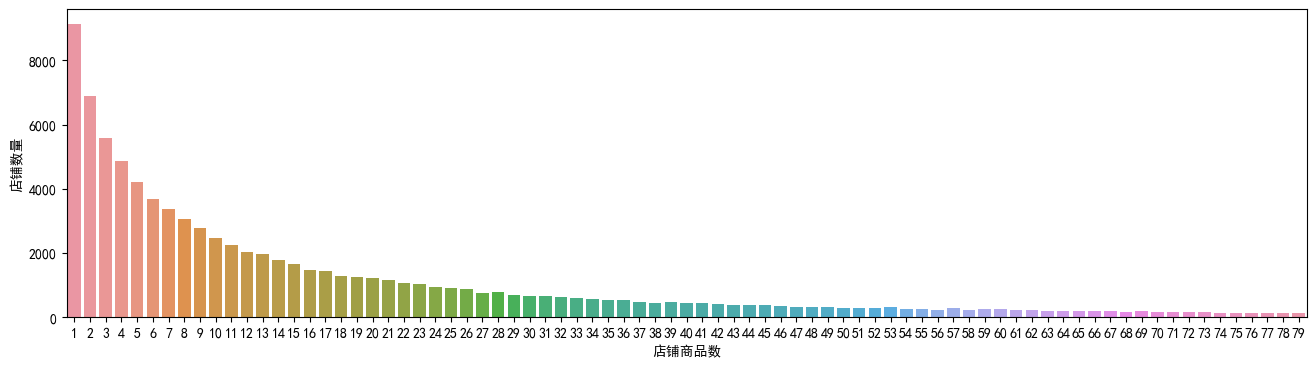

In [49]:
plt.figure(figsize=(16,4))
sns.barplot(x='店铺商品数', y='店铺数量', data=store_cnt_item_cnt[store_cnt_item_cnt['店铺商品数']<80], estimator=np.mean);

#### item_price 商品价格

In [50]:
print(item['item_price'].max(), item['item_price'].min(), item['item_price'].mean(), item['item_price'].median())

20230 1 1124.0030755446542 400.0


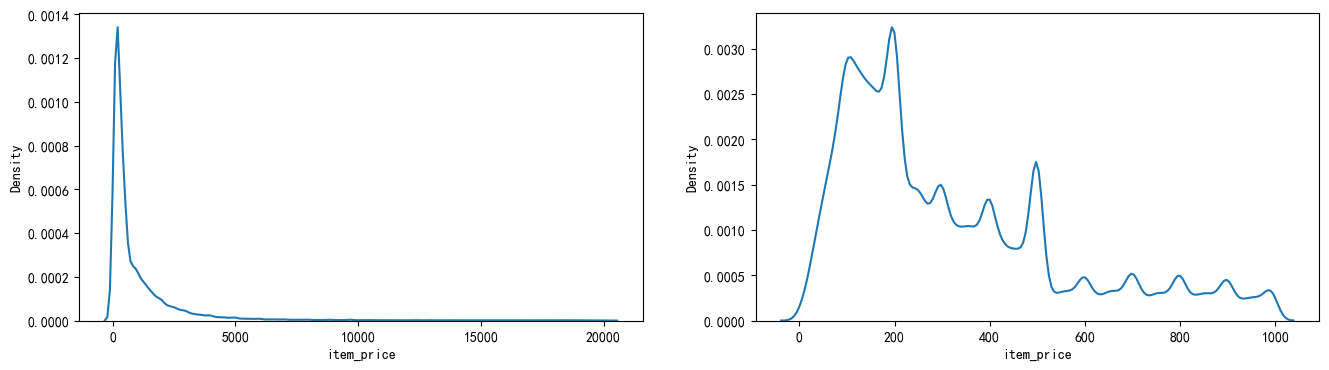

In [51]:
plt.figure(figsize=(16,4))
plt.subplot(121)
sns.kdeplot(item['item_price'])
plt.subplot(122)
sns.kdeplot(item['item_price'][item['item_price']<1000]);

In [52]:
price_cnt = item.groupby(['item_price']).size().to_frame('count').reset_index()
price_cnt.sort_values(by=['count'], ascending=False).head(10)

,item_price,count
199,200,75872
499,500,61283
99,100,33826
399,400,27670
299,300,26044
198,199,18032
999,1000,16739
699,700,12028
100,101,11972
120,121,11833


关于商品价格：商品价格是通过函数转化成了从1开始的整数，最大值为20230，最小值为1。

    * 经过对商品价格统计，大部门商品都是整百数，Top5价格200\500\100\400\300

    * TODO：整百商品探查

#### 有售商品价格

In [53]:
print(df[train]['item_price'].max(), df[train]['item_price'].min(), df[train]['item_price'].mean(), df[train]['item_price'].median())
print(df[test]['item_price'].max(), df[test]['item_price'].min(), df[test]['item_price'].mean(), df[test]['item_price'].median())

20230.0 1.0 1103.9060915681803 245.0
19907.0 1.0 778.7395852140734 270.0


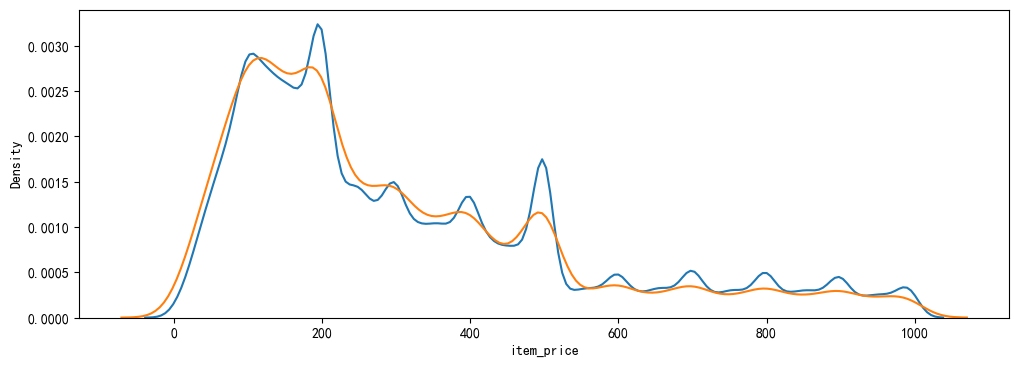

In [54]:
plt.figure(figsize=(12,4))
sns.kdeplot(df[train][df[train]['item_price']<1000][['item_id','item_price']].drop_duplicates()['item_price'])
sns.kdeplot(df[test][df[test]['item_price']<1000][['item_id','item_price']].drop_duplicates()['item_price']);
"""
在这段代码中，先选择两列（'item_id'和'item_price'）再选择一列（'item_price'）的原因是为了去除重复的商品。在这个数据集中，可能存在多个相同的'item_id'，但是它们的'item_price'可能不同。
因此，我们需要先选择这两列，然后使用drop_duplicates()函数去除这两列中重复的行，这样就可以保证每个'item_id'只对应一个'item_price'。然后，我们再选择'item_price'列作为绘图数据。
这样做的目的是为了确保我们的核密度估计图是基于每个唯一商品的价格进行绘制的。
"""

In [94]:
df[train][df[train]['item_price']<1000][['item_id','item_price']].drop_duplicates()['item_price'].shape

(1989031,)

In [95]:
df[train][df[train]['item_price']<1000]['item_price'].shape

(10339436,)

<Axes: xlabel='item_price', ylabel='Density'>

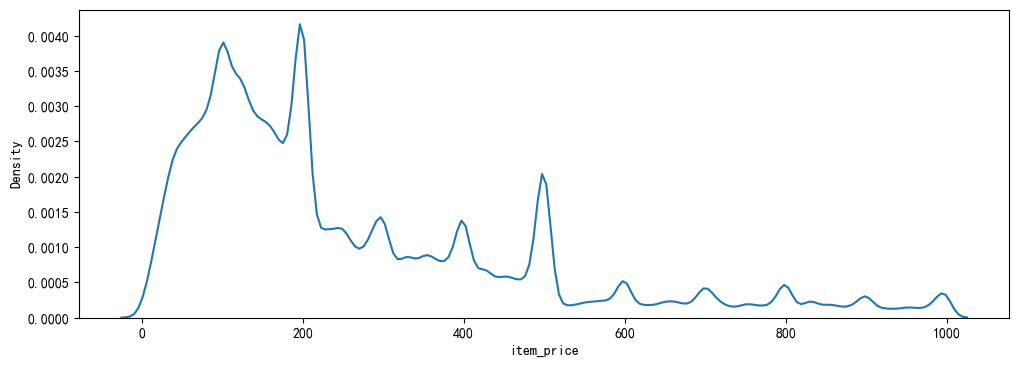

In [92]:
plt.figure(figsize=(12,4))
sns.kdeplot(df[train][df[train]['item_price']<1000]['item_price'])
# sns.kdeplot(df[test][df[test]['item_price']<1000]['item_price']);

商品价格与销量

In [100]:
df[train].groupby(['item_price'])['item_id'].nunique()

item_price
1.00         266
2.00        1305
3.00         204
4.00         152
5.00         133
            ... 
20226.00       1
20227.00       1
20228.00       1
20229.00       1
20230.00       1
Name: item_id, Length: 20191, dtype: int64

In [55]:
df[train].groupby(['item_price'])['item_id'].nunique().to_frame('商品数量').head()

,商品数量
item_price,
1.00,266
2.00,1305
3.00,204
4.00,152
5.00,133


In [56]:
price_cnt = groupby_cnt_ratio(df, 'item_price')
price_cnt.groupby(['is_train', 'buyer_country_id']).head(5)

count  count_ratio
is_train buyer_country_id item_price                     
1        xx               200.00      404366         0.04
                          500.00      201061         0.02
                          100.00      186473         0.02
                          17844.00    114631         0.01
                          121.00       92956         0.01
         yy               200.00       82625         0.04
                          500.00       48651         0.02
                          100.00       38838         0.02
                          300.00       27452         0.01
                          400.00       24144         0.01
0        yy               200.00        6846         0.04
                          500.00        3582         0.02
                          100.00        3019         0.02
                          300.00        2084         0.01
                          400.00        1765         0.01

似乎价格与销量并无直接关系

    * 但是价格为100、200、300、400、500整百数位居销量榜
    
    * xx国，17844如此高价格的商品销量这么高？

### create_order_time 订单日期

In [57]:
print(df[train]['create_order_time'].min(), df[train]['create_order_time'].max())
print(df[test]['create_order_time'].min(), df[test]['create_order_time'].max())

2018-07-13 05:54:54 2018-08-31 23:59:57
2018-07-17 07:43:40 2018-08-31 23:58:56


In [58]:
train_df_seven = df[train][df[train]['create_order_time']<pd.to_datetime('2018-08-01')]
train_df_eight = df[train][df[train]['create_order_time']>pd.to_datetime('2018-08-01')]
train_df_seven = df[train][df[train]['create_order_time']<pd.to_datetime('2018-08-01')]
train_df_eight = df[train][df[train]['create_order_time']>pd.to_datetime('2018-08-01')]

In [59]:
print('7月数据量',len(df[train][df[train]['create_order_time']<pd.to_datetime('2018-08-01')]),
      '\n8月数据量',len(df[train][df[train]['create_order_time']>pd.to_datetime('2018-08-02')]))

7月数据量 17856 
8月数据量 12838990


In [60]:
date_cnt = groupby_cnt_ratio(df, 'date')
date_cnt.columns = ['当天销量', "占比"]
date_cnt = date_cnt.reset_index()

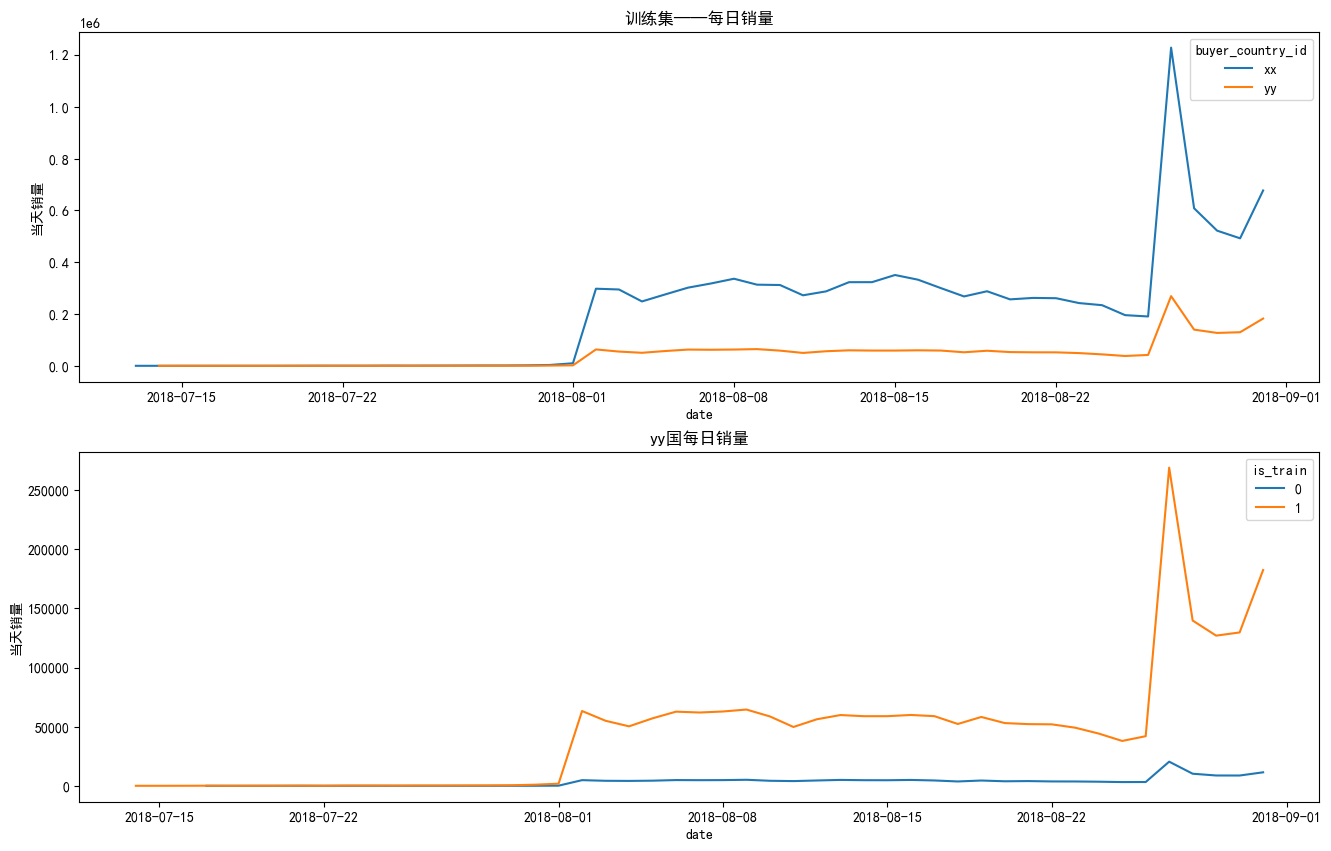

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(16,10))
sns.lineplot(x='date', y='当天销量', hue='buyer_country_id', data=date_cnt[(date_cnt['is_train']==1)], 
            estimator=np.mean, ax=ax[0]).set_title('训练集——每日销量');

sns.lineplot(x='date', y='当天销量', hue='is_train', data=date_cnt[(date_cnt['buyer_country_id']=='yy')], 
            estimator=np.mean, ax=ax[1]).set_title('yy国每日销量');

很明显：
* 训练集中7月份数据远小于8月份数据
* 训练集中xx国和yy国每日销量趋势十分相似，且在27日有个波峰

In [62]:
seven = date_cnt[date_cnt['date']<pd.to_datetime('2018-08-02')]
eight = date_cnt[date_cnt['date']>=pd.to_datetime('2018-08-02')]

C:\Users\Chen Yang\AppData\Local\Temp\ipykernel_23692\3939935538.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  seven = date_cnt[date_cnt['date']<pd.to_datetime('2018-08-02')]
C:\Users\Chen Yang\AppData\Local\Temp\ipykernel_23692\3939935538.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  eight = date_cnt[date_cnt['date']>=pd.to_datetime('2018-08-02')]


C:\Users\Chen Yang\AppData\Local\Temp\ipykernel_23692\1708177923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype(str)
C:\Users\Chen Yang\AppData\Local\Temp\ipykernel_23692\1708177923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype(str)
C:\Users\Chen Yang\AppData\Local\Temp\ipykernel_23692\1708177923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

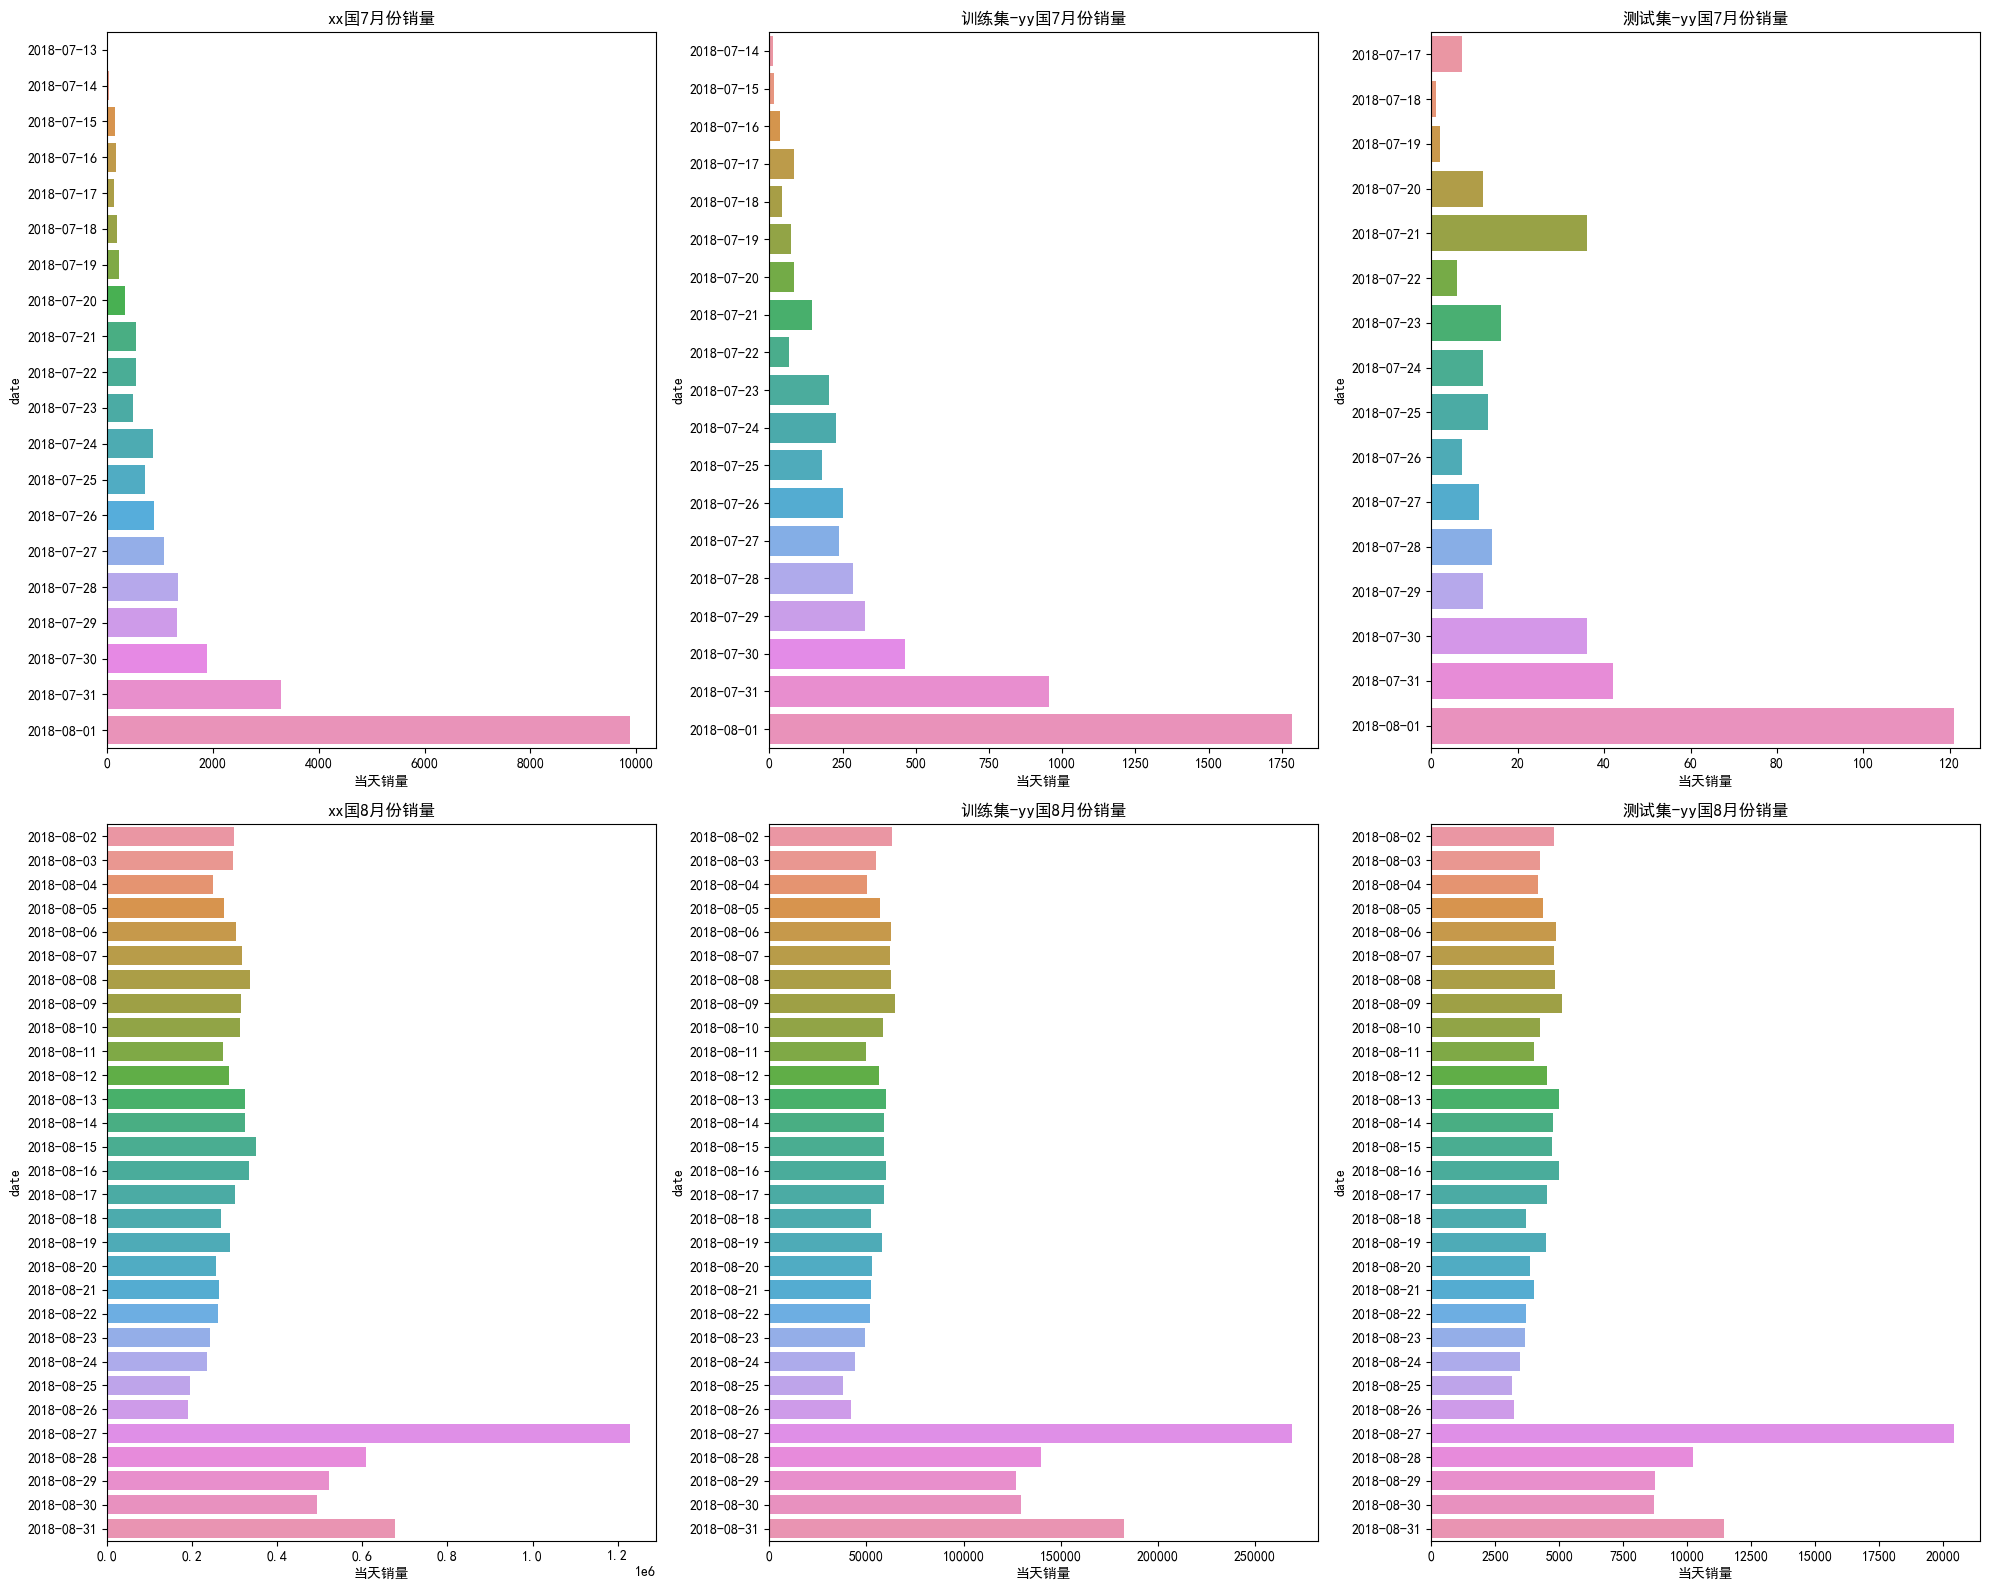

In [63]:
fig, ax = plt.subplots(2, 3, figsize=(20,16))
def barplot(ax, df, title):
    df['date'] = df['date'].astype(str)
    sns.barplot(y='date', x='当天销量' ,data=df, order=sorted(df['date'].unique()), ax=ax, estimator=np.mean)\
    .set_title(title)
    
barplot(ax[0][0], seven[(seven['is_train']==1) & (seven['buyer_country_id']=='xx')], 'xx国7月份销量')
barplot(ax[1][0], eight[(eight['is_train']==1) & (eight['buyer_country_id']=='xx')], 'xx国8月份销量')
barplot(ax[0][1], seven[(seven['is_train']==1) & (seven['buyer_country_id']=='yy')], '训练集-yy国7月份销量')
barplot(ax[1][1], eight[(eight['is_train']==1) & (eight['buyer_country_id']=='yy')], '训练集-yy国8月份销量')
barplot(ax[0][2], seven[(seven['is_train']==0) & (seven['buyer_country_id']=='yy')], '测试集-yy国7月份销量')
barplot(ax[1][2], eight[(eight['is_train']==0) & (eight['buyer_country_id']=='yy')], '测试集-yy国8月份销量')
plt.tight_layout()

数据放大后看：
* 训练集和测试集在8月份有相似的波动规律，27号出现波峰，当天剧增数据有待下一步探查

#### 每日uv与商品数(去重)

In [64]:
unique = df.groupby(['is_train', 'buyer_country_id', 'date']).agg({'buyer_admin_id':'nunique','item_id':['nunique','size']})
unique.columns = ['uv','商品数(去重)', '销量']
unique = unique.reset_index()
unique = pd.melt(unique, id_vars=['is_train', 'buyer_country_id', 'date'], value_vars=['uv', '商品数(去重)', '销量'])
unique['date'] = unique['date'].astype(str)
unique = unique[unique['date']>='2018-08-02']

这段代码主要用于对数据进行分组和聚合操作，以便于进一步的数据分析。首先，它使用 groupby 方法将数据根据 'is_train'，'buyer_country_id' 和 'date' 列进行分组。然后，使用 agg 方法对 'buyer_admin_id' 列进行去重计数（'nunique'），对 'item_id' 列进行去重计数和总计数（'size'）。这样，我们就得到了每个组的用户数量（'uv'），商品数量（'商品数(去重)'）和销量（'销量'）。

然后，代码将新生成的列名更改为 'uv'，'商品数(去重)' 和 '销量'。接着，使用 reset_index 方法重置索引，使得原来的索引变为列。

接下来，使用 pd.melt 函数将数据从宽格式转换为长格式，这样可以更方便地进行数据分析。在这个函数中，'is_train'，'buyer_country_id' 和 'date' 列被设置为标识变量，而 'uv'，'商品数(去重)' 和 '销量' 列被设置为值变量。

然后，代码将 'date' 列的数据类型转换为字符串，以便于进行字符串操作。最后，代码选择了 'date' 大于等于 '2018-08-02' 的数据行，这样可以筛选出特定日期之后的数据。

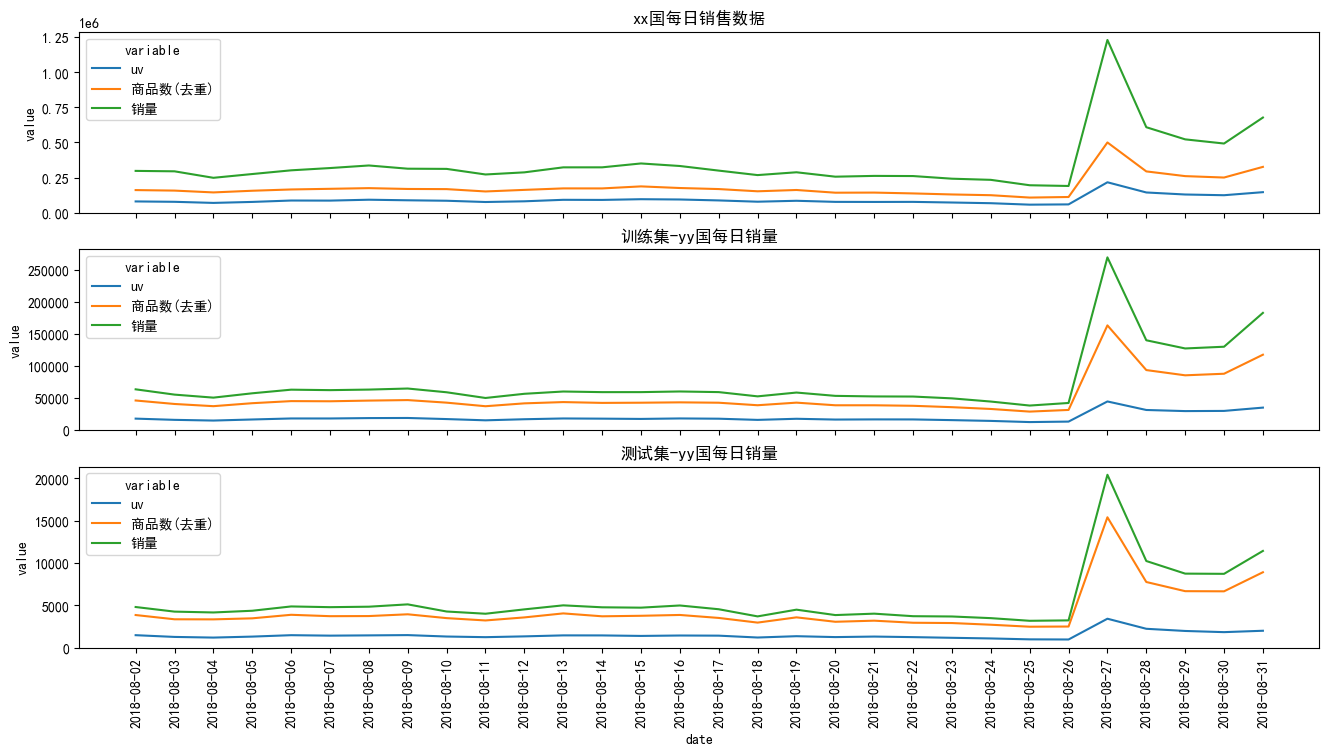

In [101]:
fig, ax = plt.subplots(3, 1, figsize=(16,8), sharex=True)
sns.lineplot(x='date', y='value', hue='variable', data=unique[(unique['is_train']==1) & (unique['buyer_country_id']=='xx')], 
             estimator=np.mean, ax=ax[0]).set_title('xx国每日销售数据');

sns.lineplot(x='date', y='value', hue='variable', data=unique[(unique['is_train']==1) & (unique['buyer_country_id']=='yy')], 
            estimator=np.mean, ax=ax[1]).set_title('训练集-yy国每日销量');

sns.lineplot(x='date', y='value', hue='variable', data=unique[(unique['is_train']==0) & (unique['buyer_country_id']=='yy')], 
            estimator=np.mean, ax=ax[2]).set_title('测试集-yy国每日销量')
plt.xticks(rotation=90);

对每日的uv、商品数和销量作图发现：
* 三者基本上呈正相关，xx国的商品单品销量更高

# BASELINE
选取用户近30次购买记录作为预测值，越近购买的商品放在越靠前的列，不够30次购买记录的用热销商品5595070填充

In [104]:
test = pd.read_csv('../data/Antai_AE_round1_test_20190626.csv')
tmp = test[test['irank']<=31].sort_values(by=['buyer_country_id', 'buyer_admin_id', 'irank'])[['buyer_admin_id','item_id','irank']]
tmp.head()

,buyer_admin_id,item_id,irank
91354,152,8410857,2
91357,152,7937154,3
91352,152,8472223,4
91356,152,4016066,5
91353,152,9891513,6


In [105]:
sub = tmp.set_index(['buyer_admin_id', 'irank']).unstack(-1)
sub.head()


item_id                                                \
irank                   2          3          4           5           6    
buyer_admin_id                                                             
152             8410857.00 7937154.00 8472223.00  4016066.00  9891513.00   
282            11721802.00 7665423.00 7665423.00 10808393.00 11310708.00   
321             1461800.00 7379845.00 9243286.00  7379845.00   627849.00   
809             2347616.00 5707010.00 6339286.00  5492003.00  1207574.00   
870            11382694.00 5999244.00 6611583.00  7412272.00  4343647.00   

                                                                         ...  \
irank                  7           8           9          10         11  ...   
buyer_admin_id                                                           ...   
152            8064216.00  8351840.00         NaN        NaN        NaN  ...   
282             623582.00  6547607.00  2605373.00  688799.00  623582.00  ...   
321            5000759.00 11774753.00 10932288.00 4813286.00 9816501.00  ...   
809            5707010.00  5492003.00  1207574.00 2262443.00        NaN  ...   
870            5546383.00  3432696.00  9589237.00 6163411.00 8952725.00  ...   

                                                        
irank           22  23  24  25  26  27  28  29  30  31  
buyer_admin_id                                          
152            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
282            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
321            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
809            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
870            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 30 columns]

In [106]:
sub.fillna(5595070).astype(int).reset_index().head()

buyer_admin_id   item_id                                                 \
irank                        2        3        4         5         6        7   
0                152   8410857  7937154  8472223   4016066   9891513  8064216   
1                282  11721802  7665423  7665423  10808393  11310708   623582   
2                321   1461800  7379845  9243286   7379845    627849  5000759   
3                809   2347616  5707010  6339286   5492003   1207574  5707010   
4                870  11382694  5999244  6611583   7412272   4343647  5546383   

                                    ...                                      \
irank         8         9       10  ...       22       23       24       25   
0       8351840   5595070  5595070  ...  5595070  5595070  5595070  5595070   
1       6547607   2605373   688799  ...  5595070  5595070  5595070  5595070   
2      11774753  10932288  4813286  ...  5595070  5595070  5595070  5595070   
3       5492003   1207574  2262443  ...  5595070  5595070  5595070  5595070   
4       3432696   9589237  6163411  ...  5595070  5595070  5595070  5595070   

                                                             
irank       26       27       28       29       30       31  
0      5595070  5595070  5595070  5595070  5595070  5595070  
1      5595070  5595070  5595070  5595070  5595070  5595070  
2      5595070  5595070  5595070  5595070  5595070  5595070  
3      5595070  5595070  5595070  5595070  5595070  5595070  
4      5595070  5595070  5595070  5595070  5595070  5595070  

[5 rows x 31 columns]

In [ ]:
sub.fillna(5595070).astype(int).reset_index().to_csv('../submit/sub.csv', index=False, header=None)

In [103]:
# 最终提交文件格式
sub = pd.read_csv('../submit/sub.csv', header = None)
sub.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,152,8410857,7937154,8472223,4016066,9891513,8064216,8351840,5595070,5595070,...,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070
1,282,11721802,7665423,7665423,10808393,11310708,623582,6547607,2605373,688799,...,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070
2,321,1461800,7379845,9243286,7379845,627849,5000759,11774753,10932288,4813286,...,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070
3,809,2347616,5707010,6339286,5492003,1207574,5707010,5492003,1207574,2262443,...,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070
4,870,11382694,5999244,6611583,7412272,4343647,5546383,3432696,9589237,6163411,...,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070,5595070


## 总结

跑过一边后，发现对于赛题的业务理解非常重要，有了一定的业务理解，便于后续的EDA还有特征工程。

因为原作者的本notebook是用来EDA的，所以可以学到很多关于pandas、matplotlib和seaborn的操作。像pd的分组操作groupby、seaborn的各种高级绘图操作，作者使用地非常熟练，也深感自己数据分析能力的薄弱，后续需要边跟随datawhale开源的仓库学习，边打竞赛来实操。

由于本次学习与毕设答辩碰在一起，所以没法抽出更能多时间来对baseline进行深入学习，比较可惜！